<a href="https://colab.research.google.com/github/ariahosseini/DeepML/blob/main/015_TensorFlow_Proj_Fifteen_GNN_Spektral_MixedLevel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install
!pip install spektral
!pip install ogb

In [ ]:
# utils
import numpy as np
import scipy.sparse as sp
from tqdm import tqdm
from ogb.graphproppred import Evaluator, GraphPropPredDataset
# sklearn
from sklearn.metrics.cluster import (completeness_score,
                                     homogeneity_score,
                                     v_measure_score)
# tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.losses import (CategoricalCrossentropy,
                                     BinaryCrossentropy,
                                     MeanSquaredError,
                                     SparseCategoricalCrossentropy)
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_accuracy, sparse_categorical_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
# spektral
from spektral.data import Dataset, DisjointLoader, Graph, BatchLoader, MixedLoader
from spektral.datasets import TUDataset, OGB, QM9
from spektral.datasets.mnist import MNIST
from spektral.datasets.citation import Cora
from spektral.models import GeneralGNN
from spektral.layers import (GCSConv, ECCConv, GlobalSumPool, GlobalAvgPool,
                             GraphMasking, GINConv, MinCutPool, GCNConv)
# from spektral.layers.convolutional import GCSConv
# from spektral.layers.pooling import MinCutPool
from spektral.transforms.normalize_adj import NormalizeAdj
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from spektral.utils.convolution import normalized_adjacency
# visual
import matplotlib.pyplot as plt

In [ ]:
# physical_devices = tf.config.list_physical_devices("GPU")
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Graph Signal Clf MNIST (Mixed Mode)

In [ ]:
# params
batch_size = 32  # batch size
epochs = 10  # number of training epochs
patience = 10  # patience for early stopping
l2_reg = 5e-4  # regularization rate for l2

In [ ]:
# load data
data = MNIST()
data.a = GCNConv.preprocess(data.a)
data.a = sp_matrix_to_sp_tensor(data.a) # create filter for GCN and convert to sparse tensor

In [ ]:
# train/valid/test split
n = 10000
data_train, data_test = data[:-n], data[-n:]
np.random.shuffle(data_train)
data_train, data_valid = data_train[:-n], data_train[-n:]

<ipython-input-74-db79d486c122>:4: UserWarning: you are shuffling a 'MNIST' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(data_train)


In [ ]:
# loaders
loader_train = MixedLoader(data_train, batch_size=batch_size, epochs=epochs)
loader_valid = MixedLoader(data_valid, batch_size=batch_size)
loader_test = MixedLoader(data_test, batch_size=batch_size)

In [ ]:
# build model
class Net(Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = GCNConv(32, activation="elu", kernel_regularizer=l2(l2_reg))
        self.conv2 = GCNConv(32, activation="elu", kernel_regularizer=l2(l2_reg))
        self.flatten = GlobalSumPool()
        self.fc1 = Dense(512, activation="relu")
        self.fc2 = Dense(10, activation="softmax")  # MNIST has ten classes

    def call(self, inputs):
        x, a = inputs
        x = self.conv1([x, a])
        x = self.conv2([x, a])
        output = self.flatten(x)
        output = self.fc1(output)
        output = self.fc2(output)
        return output

In [ ]:
# create model
model = Net()
optimizer = Adam()
loss_fn = SparseCategoricalCrossentropy()

In [ ]:
# funcs
@tf.function
def train_on_batch(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)
        acc = tf.reduce_mean(sparse_categorical_accuracy(target, predictions))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, acc

def evaluate(loader):
    results, step = [], 0
    for batch in loader:
        step += 1
        inputs, target = batch
        predictions = model(inputs, training=False)
        loss = loss_fn(target, predictions)
        acc = tf.reduce_mean(sparse_categorical_accuracy(target, predictions))
        results.append((loss, acc, len(target)))
        if step == loader.steps_per_epoch:
            results = np.array(results)
            return np.average(results[:, :-1], 0, weights=results[:, -1])

In [ ]:
# train
best_val_loss = 1e6-1
current_patience = patience
step = 0
results_train = []
for batch in loader_train:
    step += 1
    inputs, target = batch
    loss, acc = train_on_batch(inputs, target)
    results_train.append((loss, acc, len(target)))
    if step == loader_train.steps_per_epoch:
        results_valid = evaluate(loader_valid)
        if results_valid[0] < best_val_loss:
            best_val_loss = results_valid[0]
            current_patience = patience
            results_test = evaluate(loader_test)
        else:
            current_patience -= 1
            if current_patience == 0:
                print("Early stopping")
                break
        results_train = np.array(results_train)
        results_train = np.average(results_train[:, :-1], 0, weights=results_train[:, -1])
        print(
            "Train loss: {:.4f}, acc: {:.4f} | "
            "Valid loss: {:.4f}, acc: {:.4f} | "
            "Test loss: {:.4f}, acc: {:.4f}".format(*results_train, *results_valid, *results_test)
            )
        results_train = []
        step = 0

/usr/local/lib/python3.10/dist-packages/spektral/data/utils.py:221: UserWarning: you are shuffling a 'MNIST' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Train loss: 2.1822, acc: 0.2123 | Valid loss: 2.0385, acc: 0.2325 | Test loss: 2.0506, acc: 0.2267
Train loss: 2.0359, acc: 0.2388 | Valid loss: 1.8805, acc: 0.2862 | Test loss: 1.8728, acc: 0.2896
Train loss: 1.8582, acc: 0.2976 | Valid loss: 1.7940, acc: 0.3158 | Test loss: 1.7864, acc: 0.3134
Train loss: 1.8261, acc: 0.3116 | Valid loss: 1.8009, acc: 0.3156 | Test loss: 1.7864, acc: 0.3134
Train loss: 1.8193, acc: 0.3109 | Valid loss: 1.7975, acc: 0.3164 | Test loss: 1.7864, acc: 0.3134
Train loss: 1.8087, acc: 0.3158 | Valid loss: 1.7892, acc: 0.3227 | Test loss: 1.7838, acc: 0.3172
Train loss: 1.8078, acc: 0.3132 | Valid loss: 1.8588, acc: 0.2985 | Test loss: 1.7838, acc: 0.3172
Train loss: 1.8020, acc: 0.3135 | Valid loss: 1.7872, acc: 0.3210 | Test loss: 1.7785, acc: 0.3177
Train loss: 1.7984, acc: 0.3167 | Valid loss: 1.7977, acc: 0.3195 | Test loss: 1.7785, acc: 0.3177
Train loss: 1.7989, acc: 0.3175 | Valid loss: 1.7863, acc: 0.3222 | Test loss: 1.7791, acc: 0.3173


# Node Clustering On Citation Networks With MinCut Pooling (Unsupervised)

In [ ]:
@tf.function
def train_step(inputs):
    with tf.GradientTape() as tape:
        _, S_pool = model(inputs, training=True)
        loss = sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    return model.losses[0], model.losses[1], S_pool

In [ ]:
np.random.seed(1)

In [ ]:
epochs = 10  # training iterations
lr = 5e-4  # learning rate

In [ ]:
# load data
dataset = Cora()
adj, nodes, labels = dataset[0].a, dataset[0].x, dataset[0].y
adj_norm = normalized_adjacency(adj)
adj_norm = sp_matrix_to_sp_tensor(adj_norm)
num_feats = dataset.n_node_features
labels = np.argmax(labels, axis=-1)
num_clusters = labels.max() + 1

/usr/local/lib/python3.10/dist-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [ ]:
# model
node_input = Input(shape=(num_feats,), name="node_input")
adj_input = Input(shape=(None,), name="adj_input", sparse=True)
x = GCSConv(16, activation="elu")([node_input, adj_input])
x_out, adj_out, s_out = MinCutPool(num_clusters, return_selection=True)([x, adj_input])
model = Model([node_input, adj_input], [x_out, s_out])

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
# train
inputs = [nodes, adj_norm]
opt = Adam(learning_rate=lr)
loss_history = []
nmi_history = []
for _ in tqdm(range(epochs)):
    outs = train_step(inputs)
    outs = [o.numpy() for o in outs]
    loss_history.append((outs[0], outs[1], (outs[0] + outs[1])))
    s_out = np.argmax(outs[2], axis=-1)
    nmi_history.append(v_measure_score(labels, s_out))
loss_history = np.array(loss_history)

100%|██████████| 10/10 [00:01<00:00,  7.10it/s]


In [ ]:
# results
_, s_out = model(inputs, training=False)
s_out = np.argmax(s_out, axis=-1)
homo_score = homogeneity_score(labels, s_out)
comp_score = completeness_score(labels, s_out)
nmi = v_measure_score(labels, s_out)
print("Homogeneity: {:.3f}; Completeness: {:.3f}; NMI: {:.3f}".format(homo_score, comp_score, nmi))

Homogeneity: 0.055; Completeness: 0.054; NMI: 0.054


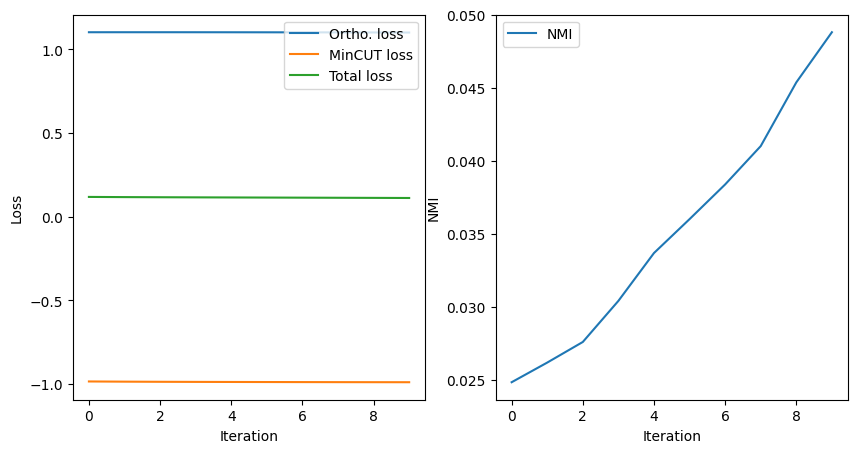

In [ ]:
# plots
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.plot(loss_history[:, 0], label="Ortho. loss")
plt.plot(loss_history[:, 1], label="MinCUT loss")
plt.plot(loss_history[:, 2], label="Total loss")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Iteration")
plt.subplot(122)
plt.plot(nmi_history, label="NMI")
plt.legend()
plt.ylabel("NMI")
plt.xlabel("Iteration")
plt.show()